## CDS ML Assignment 3
##### Group 37 - Rahul Deivasigamani (S1157698) - Joshua John Gigi (S1140063) - Anestis Pantazis (S1169388)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from scipy.special import factorial, comb
from scipy.stats import gamma, norm

### Ex 4.1

Linear regression is one of the few examples where the minimization of the loss function can be worked out exactly. In this exercise you will check that gradient descent converges to the right minimizer.

Generate $P=100$ random vectors $x^\mu$ in $N=10$ dimension, with $x_i^\mu$ i.i.d. normally distributed, and their corresponding Gaussian distributed outputs $t^\mu$.

The objective is to learn a linear model
$$y(x, w)=\sum_{j=1}^N w_j x_j$$

The best parameters $w$ are found by minimizing:
$$E(w) =\frac{1}{2P}\sum_{\mu=1}^P \left[t^\mu - y(x^\mu, w)\right]^2$$

which, as we saw in an earlier lecture, can be considered as a likelihood maximization under a Gaussian model. Proceed as follows:

1. compute the gradient and the Hessian of the loss function $E$;
2. find the solution analytically;
3. highlight the relation between the uniqueness of solutions and the Hessian - discuss possible ways to solve the problem in the case where the solution is not unique;
4. implement gradient descent and show that it converges to the solutions found in point 2.

#### Solution 4.1

##### 1.

$E(w) =\frac{1}{2P}\sum_{\mu=1}^P \left[t^\mu - y(x^\mu, w)\right]^2$

$\frac{\partial E}{\partial w_k} = \frac{\partial}{\partial w_k}\frac{1}{2P}\sum_{\mu=1}^P \left(t^\mu - \sum_{j=1}^N w_jx_j^\mu\right)^2$

For each sample,

$e^\mu = t ^ \mu − \sum_{j=1}^N ​w_j​x_j^μ​$

Then,

$\frac{\partial E}{\partial w_k} = \frac{1}{2P}\sum_{\mu=1}^P\frac{\partial}{\partial w_k} (e^\mu)^2 = \frac{1}{2P}\sum_{\mu=1}^P 2(e^\mu) \frac{\partial e^\mu}{\partial w_k}$

$ \frac{\partial e^\mu}{\partial w_k} = \frac{\partial}{\partial w_k} \left( t^\mu - \sum_{j=1}^N w_jx_j^\mu \right) = -x_k^\mu$

Therefore,

$ \frac{\partial e^\mu}{\partial w_k} = \frac{1}{2P}\sum_{\mu=1}^P 2(e^\mu) -x_k^\mu$

$$ \nabla_w E(w) = - \frac{1}{P} X^T (t-Xw)$$

For Hessian,

$H_{kl} = \frac{\partial^2 E}{\partial w_k \partial w_l} = \frac{\partial}{\partial w_l} \frac{\partial E}{\partial w_k}$

$\frac{\partial}{\partial w_l} \left( t^\mu - \sum_{j=1}^N w_jx_j^\mu \right) = -x_l^\mu$

$H_{kl} = - \frac{1}{P} \sum_{\mu=1}^P  (-x_l^\mu)(x_k^\mu) $

$H_{kl} = \frac{1}{P} \sum_{\mu=1}^P x_l^\mu x_k^\mu $

$$H = \frac{1}{P} X^TX $$

##### 2.

$ \nabla_w E(w) = 0$

$E_\lambda(w) = \frac{1}{2P} || t-Xw || ^2 + \frac{\lambda}{2} || w || ^2 = 0$

$ \nabla_w E(w) = - \frac{1}{P} X^T (t-Xw) + \lambda w = 0 $

$ \frac{1}{P} X^TXw + \lambda w = \frac{1}{P} X^Tt $

$ w^* = (X^TX + \lambda PI)^{-1}X^Tt $

$ H_\lambda = \frac{1}{P}X^TX + \lambda I$

##### 3.

The Hessian gives information regarding the curvature of the error function in the weight-space. The rank of the Hessian determines whether the quadratic form is strictly convex, flat in some points or chaotic.

if $rank(X) = N$:

$X^TX$ is invertible with the Hessian having non-zero eigenvalues. $E(w)$ is strictly convex i.e. unique global minimizer. This decomposes into the normal equation:

$w^* = (X^TX)^{-1} X^Tt$

if $rank(X) < N$:

$X^TX$ is singular with zero eigenvalues i.e. flat in some directions. $E(w)$ is not strictly convex with non-unique minimizers. i.e.

Approach 1 - using Pseudo Inverses

$w^* = X^+t + (I-X^+X)z, z \in \mathbb{R}^N, X^+ \rarr pseudo-inverse$ 

Approach 2 - Regularisation

Ridge Regression using $l_2$ penalty.

$E_\lambda(w) = \frac{1}{2P} || t-Xw || ^2 + \frac{\lambda}{2} || w || ^2$

The Hessian becomes:

$H_\lambda = \frac{1}{P} X^TX + \lambda I$

$w^*_\lambda = (X^TX ++ \lambda PI)^{-1} X^Tt$

##### 4.

In [ ]:
P = 100
N = 10

np.random.seed(0)

X = np.random.randn(P, N)
w_true = np.random.randn(N)
sigma = 0.1
noise = sigma * np.random.randn(P)
t = X @ w_true + noise

def gradient(w):
    return -(1.0 / P) * X.T @ (t - X @ w)
def loss(w):
    return 0.5 / P * np.sum((t - X @ w)**2)

eta = 1e-3
w_gd = np.zeros(N)
for it in range(5000):
    w_gd = w_gd - eta * gradient(w_gd)
    

w_analytic = np.linalg.pinv(X) @ t
H = (1.0 / P) * X.T @ X
eigvals = np.linalg.eigvalsh(H)
L = eigvals.max()

print(np.linalg.norm(w_gd-w_analytic))

0.023387306521234854


### Ex 4.2

Fill in the missing steps in the **Example** of section **Line Search**:
* provide an analytical expression for `lopt`,  `w1` and `d1`;
* check your results using a scalar minimization routine like the [Golden-section](https://en.wikipedia.org/wiki/Golden-section_search) method along the lines of [`scipy.optimize.golden`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.golden.html). You might want to implement it yourself for later use in **Ex 4.3.4**;
* check the correctness of the points in the plot.

$E(w) = \frac{\lambda_1 w_1^2 + \lambda_2 w_2^2}{2}$

$w_0=(5, 5)$

$\nabla E(w) = \begin{pmatrix}\lambda_1 w_1\\ \lambda_2 w_2 \end{pmatrix}$ $H=\begin{pmatrix}\lambda_1 & 0\\[4pt]0 & \lambda_2\end{pmatrix}$

Taking the steepest descent,

$\nabla E(w_0) = \begin{pmatrix}5\lambda_1\\ 5\lambda_2 \end{pmatrix}= g_0$

$d_0=-g_0= -\begin{pmatrix}5\lambda_1\\ 5\lambda_2 \end{pmatrix}$

$l_{opt} = -\frac{\nabla E(w_0)^Tp}{p^THp}$

Since $p=d_0=-g_0$,

$l_{opt} = -\frac{g_0^Tg_0}{g_0^THg_0}$

$g_0^Tg_0 = 25(\lambda_1^2 + \lambda_2^2)$

$g_0^THg_0 = 25(\lambda_1^3 + \lambda_2^3)$

$$l_{opt} = \frac{\lambda_1^2 + \lambda_2^2}{\lambda_1^3 + \lambda_2^3}$$

$$w_1 = w_0+l_{opt}d_0 = w_0 - l_{opt}g_0$$

$w_{1,j} = 5(1-l_{opt}\lambda_j), j = 1,2$

$$d_1 = - \nabla E(w_1) = -Hw_1 = - \begin{pmatrix}\lambda_1w_{1,1}\\\lambda_2w_{1,2} \end{pmatrix}$$

analytic lopt: 0.26153846153846155
w1 (analytic): [ 3.69230769 -0.23076923]
d1 (analytic): [-3.69230769  0.92307692]
numeric lopt (golden): 0.2615384620187429
difference: 4.802813702298181e-10


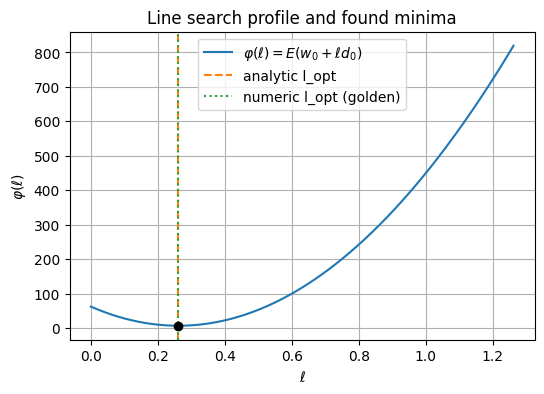

g1^T d0 (should be 0): 3.552713678800501e-15


In [ ]:
lam1 = 1.0
lam2 = 4.0

w0 = np.array([5.0, 5.0])

def E(w):
    return 0.5 * (lam1 * w[0]**2 + lam2 * w[1]**2)

def gradE(w):
    return np.array([lam1 * w[0], lam2 * w[1]])

H = np.diag([lam1, lam2])

g0 = gradE(w0)
d0 = -g0

lopt_analytic = (g0 @ g0) / (g0 @ (H @ g0))
print("analytic lopt:", lopt_analytic)

w1_analytic = w0 + lopt_analytic * d0
d1_analytic = -gradE(w1_analytic)
print("w1 (analytic):", w1_analytic)
print("d1 (analytic):", d1_analytic)

phi = lambda l: E(w0 + l * d0)

def golden_section_minimize(f, a, b, tol=1e-8, maxiter=200):
    gr = (np.sqrt(5) - 1) / 2  # 0.618...
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    fc = f(c); fd = f(d)
    it = 0
    while (b - a) > tol and it < maxiter:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - gr * (b - a)
            fc = f(c)
        else:
            a, c, fc = c, d, fd
            d = a + gr * (b - a)
            fd = f(d)
        it += 1
    return (a + b) / 2

a, b = 0.0, 10.0
lopt_numeric = golden_section_minimize(phi, a, b, tol=1e-10)
print("numeric lopt (golden):", lopt_numeric)
print("difference:", abs(lopt_numeric - lopt_analytic))

ls = np.linspace(max(0, lopt_analytic - 1.0), lopt_analytic + 1.0, 400)
phis = [phi(l) for l in ls]

plt.figure(figsize=(6,4))
plt.plot(ls, phis, label=r'$\varphi(\ell)=E(w_0+\ell d_0)$')
plt.axvline(lopt_analytic, color='C1', linestyle='--', label='analytic l_opt')
plt.axvline(lopt_numeric, color='C2', linestyle=':', label='numeric l_opt (golden)')
plt.scatter([lopt_analytic], [phi(lopt_analytic)], color='black', zorder=5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\varphi(\ell)$')
plt.legend()
plt.title('Line search profile and found minima')
plt.grid(True)
plt.show()

g1 = gradE(w1_analytic)
print("g1^T d0 (should be 0):", float(g1 @ d0))
